### Load Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/tmp/ipykernel_26182/747812647.py:4: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


### Load Data

In [2]:
#Load the dataset
data = pd.read_csv('data/Claim Denial Updated V7.csv')
data.head()

Unnamed: 0                          CLAIM_ID  CLAIM_LINE_NUMBER CLAIM_TYPE  \
0        29.0  6f8ab0ad49f3109b68bf3e50e87d4221                  2          I   
1        36.0  dbd45f6f0880890686792cf667df13a4                  2          I   
2         NaN  d96ea367dfac86ff2888aa6426c183b3                  2          I   
3        53.0  a187d9f9f2345c62ea6b37876e242572                  2          I   
4        56.0  d908471a8f9d511182fa13fe0fa2f514                  1          I   

                       ENCOUNTER_ID  PATIENT_ID               Name  \
0  6f8ab0ad49f3109b68bf3e50e87d4221       10017       Robert Jones   
1  dbd45f6f0880890686792cf667df13a4       10046  Patricia Williams   
2  d96ea367dfac86ff2888aa6426c183b3       10126     Linda Anderson   
3  a187d9f9f2345c62ea6b37876e242572       10200       Donald Jones   
4  d908471a8f9d511182fa13fe0fa2f514       10174      Mark Anderson   

  CLAIM_START_DATE CLAIM_END_DATE CLAIM_LINE_START_DATE  ... MS_DRG  \
0        1/25/2018      1/25/2018             1/25/2018  ...    683   
1         3/6/2018       3/6/2018              3/6/2018  ...    470   
2         4/1/2018       4/1/2018              4/1/2018  ...    641   
3         2/3/2016       2/3/2016              2/3/2016  ...    378   
4        5/19/2016      5/19/2016             5/19/2016  ...    312   

  PROCEDURE_DATE  Year CLAIM_STATUS    PAYERS      DENIAL_CATEGORY  \
0      1/24/2018  2018       Denied  Medicare          Eligibility   
1       3/5/2018  2018       Denied  Medicare         Coding Error   
2      3/31/2018  2018       Denied    Humana  Prior Authorization   
3       2/2/2016  2016       Denied  Medicare    Benefit Exhausted   
4      5/18/2016  2016       Denied     Cigna         Coding Error   

   REASON_CODE  PHYSICIAN_NPI  PROCEDURE_CODE  \
0         22.0     1078460050         0RGA071   
1         27.0     1291298745         0W3P8ZZ   
2         74.0     1676598018         0D9670Z   
3         32.0     1684233067         4A023N7   
4          8.0     1570173900         06BQ4ZZ   

                               PROCEDURE_DESCRIPTION  
0  Charges do not meet qualifications for emergen...  
1                    Processed in Excess of charges.  
2  Lifetime benefit maximum has been reached for ...  
3                   ESRD network support adjustment.  
4  The procedure code is inconsistent with the pr...  

[5 rows x 64 columns]

In [3]:
data.shape

(5600, 64)

In [4]:
""" data['CLAIM_DATEDIFF'] = (pd.to_datetime(data['CLAIM_END_DATE']) - pd.to_datetime(data['CLAIM_START_DATE'])).dt.days
data['CLAIM_LINE_DATEDIFF'] = (pd.to_datetime(data['CLAIM_LINE_END_DATE']) - pd.to_datetime(data['CLAIM_LINE_START_DATE'])).dt.days
data['COVERAGE_DATEDIFF'] = (pd.to_datetime(data['COVERAGE_END_DATE']) - pd.to_datetime(data['COVERAGE_START_DATE'])).dt.days
data['ENCOUNTER_DATEDIFF'] = (pd.to_datetime(data['ENCOUNTER_END_DATE']) - pd.to_datetime(data['ENCOUNTER_START_DATE'])).dt.days

engg_features = ['CLAIM_DATEDIFF', 'CLAIM_LINE_DATEDIFF','COVERAGE_DATEDIFF','ENCOUNTER_DATEDIFF']

data.shape

data.loc[:,engg_features].describe() """

" data['CLAIM_DATEDIFF'] = (pd.to_datetime(data['CLAIM_END_DATE']) - pd.to_datetime(data['CLAIM_START_DATE'])).dt.days\ndata['CLAIM_LINE_DATEDIFF'] = (pd.to_datetime(data['CLAIM_LINE_END_DATE']) - pd.to_datetime(data['CLAIM_LINE_START_DATE'])).dt.days\ndata['COVERAGE_DATEDIFF'] = (pd.to_datetime(data['COVERAGE_END_DATE']) - pd.to_datetime(data['COVERAGE_START_DATE'])).dt.days\ndata['ENCOUNTER_DATEDIFF'] = (pd.to_datetime(data['ENCOUNTER_END_DATE']) - pd.to_datetime(data['ENCOUNTER_START_DATE'])).dt.days\n\nengg_features = ['CLAIM_DATEDIFF', 'CLAIM_LINE_DATEDIFF','COVERAGE_DATEDIFF','ENCOUNTER_DATEDIFF']\n\ndata.shape\n\ndata.loc[:,engg_features].describe() "

In [5]:
data_v1 = pd.read_csv('data/Claim Denial Updated.csv')
data_v1.shape

(5600, 68)

In [6]:
set(data.columns).difference(data_v1.columns)

{'APPROVED_CHARGE',
 'Age',
 'PHYSICIAN_NPI',
 'PROCEDURE_CODE',
 'PROCEDURE_DESCRIPTION',
 'TOTAL_CHARGES'}

In [7]:
set(data_v1.columns).difference(data.columns)

{'EDUCATION',
 'HIGH_COST_CLAIMANTS',
 'HOUSING',
 'MINORITY_STATUS',
 'NO_OF_MEMBERS_IN_FAMILY',
 'PAID_AMOUNT',
 'POVERTY_LEVEL',
 'PRE_EXISTING_ILLNESS',
 'REASON',
 'SOCIALLY_VULNERABLE'}

In [8]:
columns_to_remove = ['Unnamed: 0' ,'CLAIM_TYPE', 'CLAIM_ID' , 'CLAIM_LINE_NUMBER', 'ENCOUNTER_ID', 'PATIENT_ID', 'Name',
'CLAIM_START_DATE', 'CLAIM_END_DATE', 'CLAIM_LINE_START_DATE','CLAIM_LINE_END_DATE',
'PLACE_OF_SERVICE_DESCRIPTION','REVENUE_CENTER_DESCRIPTION','RENDERING_NPI',
'FACILITY_NPI','DISCHARGE_DISPOSITION_DESCRIPTION','DATA_SOURCE','COVERAGE_START_DATE',
'COVERAGE_END_DATE','PAYER', 'PAYER_TYPE', 'BIRTH_DATE','ZIP_CODE','DECEASED_FLAG',
'CONDITION_DATE','CONDITION_TYPE','CODE_TYPE','DESCRIPTION','MONTH','YEAR','ENCOUNTER_START_DATE',
'ENCOUNTER_END_DATE','ADMIT_SOURCE_DESCRIPTION','ADMIT_TYPE_DESCRIPTION',
'PROCEDURE_DATE', 'Year','PHYSICIAN_NPI']


xxx  = ['PLACE_OF_SERVICE_CODE' , 'REVENUE_CENTER_CODE', 'DISCHARGE_DISPOSITION_CODE','DUAL_STATUS', 
        'MEDICARE_STATUS','ADMIT_SOURCE_CODE','ADMIT_TYPE_CODE', 'MS_DRG'] #HIGH_COST_CLAIMANTS

In [9]:
#CLAIM_STATUS: Replace 'Partially Approved' with 'Approved'
#data['CLAIM_STATUS'] = data['CLAIM_STATUS'].replace('Partially Approved','Approved')
data['CLAIM_STATUS'].value_counts()

Approved    3687
Denied      1913
Name: CLAIM_STATUS, dtype: int64

In [10]:
#Set DENIAL_CATEGORY to NOT_APPLICABLE for all 'Approved'  Claims
data['DENIAL_CATEGORY'] = data['DENIAL_CATEGORY'].fillna('NOT_APPLICABLE')
data['DENIAL_CATEGORY'].value_counts()

NOT_APPLICABLE          3687
Prior Authorization     1114
Eligibility              414
Coding Error             207
Benefit Exhausted         63
Prior Authorization       58
Others                    29
Prior AUthorization       28
Name: DENIAL_CATEGORY, dtype: int64

In [11]:
data['DENIAL_CATEGORY'].value_counts().index

Index(['NOT_APPLICABLE', 'Prior Authorization', 'Eligibility', 'Coding Error',
       'Benefit Exhausted', 'Prior Authorization ', 'Others',
       'Prior AUthorization'],
      dtype='object')

In [12]:
data['DENIAL_CATEGORY'].replace('Prior Authorization ','Prior Authorization', inplace=True)
data['DENIAL_CATEGORY'].replace('Prior AUthorization','Prior Authorization', inplace=True)

In [13]:
""" data[data['DENIAL_CATEGORY'] =='Prior Authorization '] = 'Prior Authorization'
data[data['DENIAL_CATEGORY'] =='Prior AUthorization'] = 'Prior Authorization' """

" data[data['DENIAL_CATEGORY'] =='Prior Authorization '] = 'Prior Authorization'\ndata[data['DENIAL_CATEGORY'] =='Prior AUthorization'] = 'Prior Authorization' "

In [14]:
data['DENIAL_CATEGORY'].value_counts()

NOT_APPLICABLE         3687
Prior Authorization    1200
Eligibility             414
Coding Error            207
Benefit Exhausted        63
Others                   29
Name: DENIAL_CATEGORY, dtype: int64

##### PAYERS is not available for Approved Claims. Impute based on the distribution of avaialble payers.

In [15]:
""" # Calculate the value counts of non-null values, normalized
value_counts = data['PAYERS'].value_counts(normalize=True)
value_counts

# Create a list of the categories to fillna with, based on their normalized frequencies
fill_values = list(value_counts.index)
fill_weights = list(value_counts.values)


print(f'fill_values :{fill_values}')
print(f'fill_weights :{fill_weights}')

# Fill the NaN values using the weighted random choice of categories
data['PAYERS'] = data['PAYERS'].fillna(pd.Series(np.random.choice(fill_values, size=len(data.index), p=fill_weights))) 

print(f'Before imputation: \n {value_counts}')
print('*'*50)

print(f"After imputation: \n {data['PAYERS'].value_counts(normalize=True)}")
"""

' # Calculate the value counts of non-null values, normalized\nvalue_counts = data[\'PAYERS\'].value_counts(normalize=True)\nvalue_counts\n\n# Create a list of the categories to fillna with, based on their normalized frequencies\nfill_values = list(value_counts.index)\nfill_weights = list(value_counts.values)\n\n\nprint(f\'fill_values :{fill_values}\')\nprint(f\'fill_weights :{fill_weights}\')\n\n# Fill the NaN values using the weighted random choice of categories\ndata[\'PAYERS\'] = data[\'PAYERS\'].fillna(pd.Series(np.random.choice(fill_values, size=len(data.index), p=fill_weights))) \n\nprint(f\'Before imputation: \n {value_counts}\')\nprint(\'*\'*50)\n\nprint(f"After imputation: \n {data[\'PAYERS\'].value_counts(normalize=True)}")\n'

In [16]:
data['PAYERS'].value_counts()

BCBS        1686
Medicare    1401
Aetna        957
Cigna        723
Humana       557
UHG          276
Name: PAYERS, dtype: int64

In [17]:
print(f"Total Denied Claims: {data[data['CLAIM_STATUS'] == 'Denied'].shape[0]}")
print(f"Denied Claims with Non-Empty Reason code: {data[data['CLAIM_STATUS'] == 'Denied']['REASON_CODE'].value_counts().sum()}")
print(f"Denied Cliams with empty Reason Code : {data[data['CLAIM_STATUS'] == 'Denied']['REASON_CODE'].isna().sum()}")

Total Denied Claims: 1913
Denied Claims with Non-Empty Reason code: 1913
Denied Cliams with empty Reason Code : 0


In [18]:
data.shape

(5600, 64)

##### Add a new REASON_CODE='APPROVED' for Approved Claims

In [19]:
# Count of value in reason code
data['CLAIM_STATUS'].value_counts()

Approved    3687
Denied      1913
Name: CLAIM_STATUS, dtype: int64

In [20]:
#sorted(data['REASON_CODE'].unique())

In [21]:
#Add reason code for APPROVED CLAIMs : AP01
data['REASON_CODE'].fillna(1.0, inplace=True)

In [22]:
print(data.where(data.CLAIM_STATUS =='Denied')['REASON_CODE'].value_counts().sum())
print(data.where(data.CLAIM_STATUS =='Denied')['REASON_CODE'].isna().sum())

1913
3687


In [23]:
# Count of value in reason code
data['REASON_CODE'].value_counts()

1.0      3687
115.0     330
29.0      321
90.0      318
32.0       34
12.0       30
5.0        30
7.0        30
6.0        30
4.0        30
13.0       30
9.0        30
19.0       30
10.0       30
14.0       30
11.0       30
16.0       30
18.0       30
24.0       29
21.0       29
117.0      29
26.0       29
74.0       29
76.0       29
8.0        29
31.0       29
33.0       29
20.0       29
111.0      29
116.0      29
27.0       29
23.0       29
112.0      29
22.0       29
114.0      28
118.0      28
Name: REASON_CODE, dtype: int64

In [24]:
len(data['REASON_CODE'].unique())

36

<AxesSubplot: >

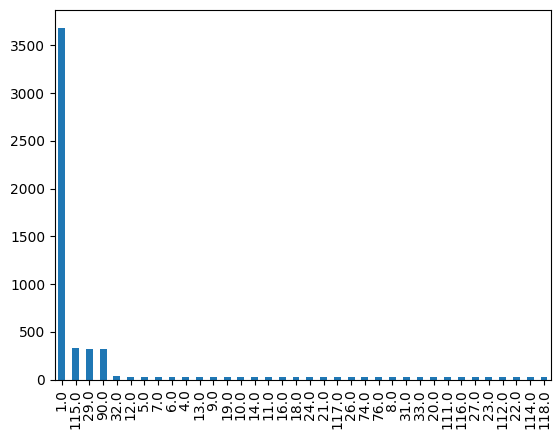

In [25]:
# Diagramatic representation of reason code count
data['REASON_CODE'].value_counts().plot(kind='bar')

### Remove insignificant features
- Drop zero variance columns
- Drop Date Columns

In [26]:
col_removed_df = data.drop(columns_to_remove, axis=1)
col_removed_df.shape

(5600, 27)

In [27]:
col_removed_df.describe()

PLACE_OF_SERVICE_CODE  REVENUE_CENTER_CODE  SERVICE_UNIT_QUANTITY  \
count            5600.000000          5600.000000            5600.000000   
mean               31.646429           405.167143               4.829286   
std                27.116782           162.077272              20.936729   
min                11.000000            23.000000               0.000000   
25%                22.000000           300.000000               1.000000   
50%                23.000000           307.000000               1.000000   
75%                23.000000           460.000000               1.000000   
max                99.000000           983.000000             510.000000   

       APPROVED_CHARGE  TOTAL_CHARGES  DISCHARGE_DISPOSITION_CODE  \
count      5600.000000    5600.000000                 5600.000000   
mean       1739.549804    1786.376411                    2.423214   
std        3131.716577    3119.435560                    6.430623   
min         -82.700000     -36.430000                    0.000000   
25%          53.240000     109.037500                    1.000000   
50%         253.040000     343.605000                    1.000000   
75%        1766.230000    1786.770000                    1.000000   
max       28868.840000   28868.840000                   70.000000   

               Age  MEDICARE_STATUS  ADMIT_SOURCE_CODE  ADMIT_TYPE_CODE  \
count  5600.000000      5600.000000        5600.000000      5600.000000   
mean     76.390179        11.632143           2.326071         1.928750   
std      12.552604         4.446146           1.228537         0.829507   
min      19.000000         0.000000           1.000000         1.000000   
25%      71.000000        10.000000           1.000000         1.000000   
50%      76.000000        10.000000           2.000000         2.000000   
75%      84.000000        10.000000           4.000000         3.000000   
max     104.000000        20.000000           4.000000         3.000000   

            MS_DRG  REASON_CODE  
count  5600.000000  5600.000000  
mean    372.866429    20.689107  
std     206.904630    37.008887  
min      42.000000     1.000000  
25%     247.000000     1.000000  
50%     309.000000     1.000000  
75%     442.000000    23.000000  
max     920.000000   118.000000

In [28]:
col_removed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5600 entries, 0 to 5599
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   BILL_TYPE_CODE              5600 non-null   object 
 1   PLACE_OF_SERVICE_CODE       5600 non-null   int64  
 2   REVENUE_CENTER_CODE         5600 non-null   int64  
 3   SERVICE_UNIT_QUANTITY       5600 non-null   int64  
 4   APPROVED_CHARGE             5600 non-null   float64
 5   TOTAL_CHARGES               5600 non-null   float64
 6   HCPCS_CODE                  5600 non-null   object 
 7   DISCHARGE_DISPOSITION_CODE  5600 non-null   int64  
 8   GENDER                      5600 non-null   object 
 9   Age                         5600 non-null   int64  
 10  RACE                        5600 non-null   object 
 11  STATE                       5600 non-null   object 
 12  COUNTY                      5600 non-null   object 
 13  CODE                        5600 

In [29]:
col_removed_df.isna().sum()

BILL_TYPE_CODE                0
PLACE_OF_SERVICE_CODE         0
REVENUE_CENTER_CODE           0
SERVICE_UNIT_QUANTITY         0
APPROVED_CHARGE               0
TOTAL_CHARGES                 0
HCPCS_CODE                    0
DISCHARGE_DISPOSITION_CODE    0
GENDER                        0
Age                           0
RACE                          0
STATE                         0
COUNTY                        0
CODE                          0
PRESENT_ON_ADMIT              0
DUAL_STATUS                   0
MEDICARE_STATUS               0
ENCOUNTER_TYPE                0
ADMIT_SOURCE_CODE             0
ADMIT_TYPE_CODE               0
MS_DRG                        0
CLAIM_STATUS                  0
PAYERS                        0
DENIAL_CATEGORY               0
REASON_CODE                   0
PROCEDURE_CODE                0
PROCEDURE_DESCRIPTION         0
dtype: int64

### Devide into Categorical and Numerical columns

In [30]:
# Selection of column bsed on numerical and cateogorical value.
numerical_df = col_removed_df.select_dtypes(include='number')
categorical_df = col_removed_df.select_dtypes(include='object')

In [31]:
# Shape of numerical and cateogorical coloumn
numerical_df.shape, categorical_df.shape

((5600, 12), (5600, 15))

In [32]:
cat_col_from_numerical_df = ['PLACE_OF_SERVICE_CODE' , 'REVENUE_CENTER_CODE', 'DISCHARGE_DISPOSITION_CODE', 'MEDICARE_STATUS','ADMIT_SOURCE_CODE','ADMIT_TYPE_CODE', 'MS_DRG']
len(cat_col_from_numerical_df)

7

In [33]:
categorcal_cols = categorical_df.columns.tolist()
len(categorcal_cols)

15

In [34]:
categorcal_cols.extend(cat_col_from_numerical_df)
len(categorcal_cols)

22

In [35]:
categorical_df =  col_removed_df[categorcal_cols]
categorical_df.shape

(5600, 22)

In [36]:
numerical_cols = list(set(col_removed_df.columns).difference(set(categorical_df.columns)))
numerical_cols

['APPROVED_CHARGE',
 'REASON_CODE',
 'Age',
 'SERVICE_UNIT_QUANTITY',
 'TOTAL_CHARGES']

**NO_OF_MEMBERS_IN_FAMILY** will be investigated again.

In [37]:

numerical_df = col_removed_df[numerical_cols]
numerical_df.shape

(5600, 5)

In [38]:

set(numerical_df.columns).intersection(categorical_df.columns)

set()

In [39]:
numerical_df.shape, categorical_df.shape

((5600, 5), (5600, 22))

In [40]:
#Null Check
numerical_df.isna().sum()

APPROVED_CHARGE          0
REASON_CODE              0
Age                      0
SERVICE_UNIT_QUANTITY    0
TOTAL_CHARGES            0
dtype: int64

In [41]:
#Null Check
categorical_df.isna().sum()

BILL_TYPE_CODE                0
HCPCS_CODE                    0
GENDER                        0
RACE                          0
STATE                         0
COUNTY                        0
CODE                          0
PRESENT_ON_ADMIT              0
DUAL_STATUS                   0
ENCOUNTER_TYPE                0
CLAIM_STATUS                  0
PAYERS                        0
DENIAL_CATEGORY               0
PROCEDURE_CODE                0
PROCEDURE_DESCRIPTION         0
PLACE_OF_SERVICE_CODE         0
REVENUE_CENTER_CODE           0
DISCHARGE_DISPOSITION_CODE    0
MEDICARE_STATUS               0
ADMIT_SOURCE_CODE             0
ADMIT_TYPE_CODE               0
MS_DRG                        0
dtype: int64

In [42]:
data.CLAIM_STATUS.value_counts()

Approved    3687
Denied      1913
Name: CLAIM_STATUS, dtype: int64

In [43]:
total_cat_cols = 0
for col in categorical_df.columns:
    #print(col)
    total_cat_cols += len(categorical_df.loc[:,col].value_counts())
print(f'total_cat_cols : {total_cat_cols}')

total_cat_cols : 2415


In [44]:
#HANDLE NUMERICAL DF
numerical_df.head()

APPROVED_CHARGE  REASON_CODE  Age  SERVICE_UNIT_QUANTITY  TOTAL_CHARGES
0            44.62         22.0   38                      1         225.62
1          1457.06         27.0   84                     10        1638.06
2           254.95         74.0   81                      1         326.95
3             4.09         32.0   92                      1          76.09
4            56.11          8.0   69                      1         173.11

In [45]:
categorical_df.head()

BILL_TYPE_CODE HCPCS_CODE  GENDER   RACE           STATE         COUNTY  \
0            131      82306    male  white  North Carolina       Cherokee   
1            131      J1644  female  white            Utah         Summit   
2            131      76642  female  white        Delaware     New Castle   
3            131      85610    male  white     Connecticut      Fairfield   
4            131      G0463    male  white            Iowa  Pottawattamie   

    CODE PRESENT_ON_ADMIT DUAL_STATUS        ENCOUNTER_TYPE  ...  \
0  G9340                Y           5       Acute Inpatient  ...   
1  E1142                0           0                 Other  ...   
2   I480                0           4  Emergency Department  ...   
3    I10                0           2                 Other  ...   
4   I255                0           7                 Other  ...   

       DENIAL_CATEGORY PROCEDURE_CODE  \
0          Eligibility        0RGA071   
1         Coding Error        0W3P8ZZ   
2  Prior Authorization        0D9670Z   
3    Benefit Exhausted        4A023N7   
4         Coding Error        06BQ4ZZ   

                               PROCEDURE_DESCRIPTION PLACE_OF_SERVICE_CODE  \
0  Charges do not meet qualifications for emergen...                    21   
1                    Processed in Excess of charges.                    23   
2  Lifetime benefit maximum has been reached for ...                    23   
3                   ESRD network support adjustment.                    99   
4  The procedure code is inconsistent with the pr...                    99   

  REVENUE_CENTER_CODE  DISCHARGE_DISPOSITION_CODE  MEDICARE_STATUS  \
0                 300                           1               20   
1                 636                           1               10   
2                 402                           1               10   
3                 300                           1               10   
4                 510                           1               20   

   ADMIT_SOURCE_CODE  ADMIT_TYPE_CODE  MS_DRG  
0                  4                3     683  
1                  2                1     470  
2                  4                1     641  
3                  4                3     378  
4                  2                3     312  

[5 rows x 22 columns]

In [46]:
merged = pd.concat([numerical_df, categorical_df],axis=1 )
merged.shape

(5600, 27)

In [47]:
merged.head()

APPROVED_CHARGE  REASON_CODE  Age  SERVICE_UNIT_QUANTITY  TOTAL_CHARGES  \
0            44.62         22.0   38                      1         225.62   
1          1457.06         27.0   84                     10        1638.06   
2           254.95         74.0   81                      1         326.95   
3             4.09         32.0   92                      1          76.09   
4            56.11          8.0   69                      1         173.11   

  BILL_TYPE_CODE HCPCS_CODE  GENDER   RACE           STATE  ...  \
0            131      82306    male  white  North Carolina  ...   
1            131      J1644  female  white            Utah  ...   
2            131      76642  female  white        Delaware  ...   
3            131      85610    male  white     Connecticut  ...   
4            131      G0463    male  white            Iowa  ...   

       DENIAL_CATEGORY PROCEDURE_CODE  \
0          Eligibility        0RGA071   
1         Coding Error        0W3P8ZZ   
2  Prior Authorization        0D9670Z   
3    Benefit Exhausted        4A023N7   
4         Coding Error        06BQ4ZZ   

                               PROCEDURE_DESCRIPTION PLACE_OF_SERVICE_CODE  \
0  Charges do not meet qualifications for emergen...                    21   
1                    Processed in Excess of charges.                    23   
2  Lifetime benefit maximum has been reached for ...                    23   
3                   ESRD network support adjustment.                    99   
4  The procedure code is inconsistent with the pr...                    99   

  REVENUE_CENTER_CODE DISCHARGE_DISPOSITION_CODE MEDICARE_STATUS  \
0                 300                          1              20   
1                 636                          1              10   
2                 402                          1              10   
3                 300                          1              10   
4                 510                          1              20   

  ADMIT_SOURCE_CODE ADMIT_TYPE_CODE MS_DRG  
0                 4               3    683  
1                 2               1    470  
2                 4               1    641  
3                 4               3    378  
4                 2               3    312  

[5 rows x 27 columns]

### Addressing duplicate rows

In [48]:
merged[merged.duplicated()].shape

(29, 27)

In [49]:
merged.shape

(5600, 27)

There are duplicate rows. We'll be removing those.

In [50]:
merged_no_dup = merged.drop_duplicates()
merged_no_dup.shape

(5571, 27)

### Pandas Profiling to understand the features & their relationships

In [51]:
profile = ProfileReport(merged_no_dup, title="CLAIMS DENIAL ANALYSIS",html={"style":{"full_width":True}})
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [52]:
profile.to_file(output_file="cliams_denial.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [53]:
len(categorcal_cols)

22

In [54]:
categorcal_cols

['BILL_TYPE_CODE',
 'HCPCS_CODE',
 'GENDER',
 'RACE',
 'STATE',
 'COUNTY',
 'CODE',
 'PRESENT_ON_ADMIT',
 'DUAL_STATUS',
 'ENCOUNTER_TYPE',
 'CLAIM_STATUS',
 'PAYERS',
 'DENIAL_CATEGORY',
 'PROCEDURE_CODE',
 'PROCEDURE_DESCRIPTION',
 'PLACE_OF_SERVICE_CODE',
 'REVENUE_CENTER_CODE',
 'DISCHARGE_DISPOSITION_CODE',
 'MEDICARE_STATUS',
 'ADMIT_SOURCE_CODE',
 'ADMIT_TYPE_CODE',
 'MS_DRG']

In [55]:
pd.get_dummies(merged_no_dup,columns=categorcal_cols,drop_first=True).shape

(5571, 2398)

**HCPCS_CODE** has a high cardinality: 604 distinct values	High cardinality

**COUNTY** has a high cardinality: 306 distinct values	High cardinality

**CODE** has a high cardinality: 1118 distinct values

<AxesSubplot: >

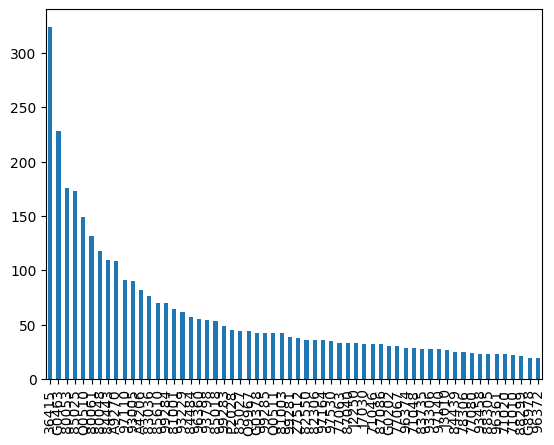

In [56]:
merged_no_dup['HCPCS_CODE'].value_counts()[:60].plot(kind='bar')

In [57]:
merged_no_dup['HCPCS_CODE'].value_counts()[:61].index

Index(['36415', 'G0463', '80053', '85025', 'Q0510', '80061', '80048', '84443',
       'A9270', '97110', '93005', 'A4206', '83036', '85610', '99284', '81001',
       '93229', '84484', '96360', '93798', '85018', '99283', 'P2028', '85027',
       'Q9967', 'G0378', '99285', 'Q0511', '81003', '99281', 'Z7512', '82550',
       '82306', '97164', '97530', '77063', '87040', 'J2250', 'J7030', '71046',
       '87086', 'G0202', '77067', '96374', '71048', '83735', '93306', '97140',
       'J3010', '84439', '78306', '77080', '93458', '88305', '96361', '71020',
       '71010', '88299', 'G8978', '96372', 'G8979'],
      dtype='object')

In [58]:
merged_no_dup['HCPCS_CODE'].value_counts().sort_values(ascending=False)[:20]

36415    324
G0463    228
80053    176
85025    173
Q0510    149
80061    132
80048    118
84443    110
A9270    109
97110     91
93005     90
A4206     82
83036     76
85610     70
99284     70
81001     64
93229     62
84484     57
96360     55
93798     54
Name: HCPCS_CODE, dtype: int64

<AxesSubplot: >

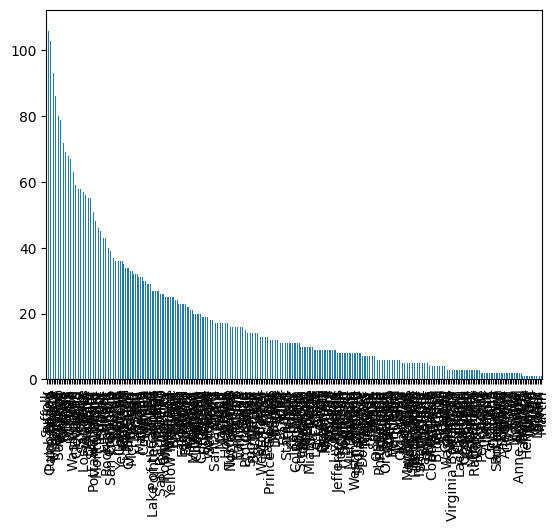

In [59]:
merged_no_dup['COUNTY'].value_counts().plot(kind='bar')

In [60]:
merged_no_dup['COUNTY'].value_counts()[:50]

Suffolk          107
Bailey           106
Cumberland       103
Palm Beach        98
La Porte          93
Middlesex         86
Fairfield         81
King              80
San Diego         79
Warrick           73
Ventura           72
Orange            69
Cook              69
Volusia           68
Wichita           67
Door              65
Washington        63
Douglas           59
Cleveland         58
Harris            58
Horry             58
Knox              58
Salt Lake         57
Los Angeles       56
Madison           56
Delaware          55
Smith             55
Sunflower         53
Pottawattamie     51
Clatsop           48
Montgomery        47
Polk              46
Clermont          45
Sussex            44
Butler            43
Kent              43
Rockingham        43
Hamilton          40
Coahoma           39
San Francisco     38
Summit            37
Bergen            36
Warren            36
Lucas             36
Cherokee          36
Yellowstone       36
Oakland           35
Jefferson    

<AxesSubplot: >

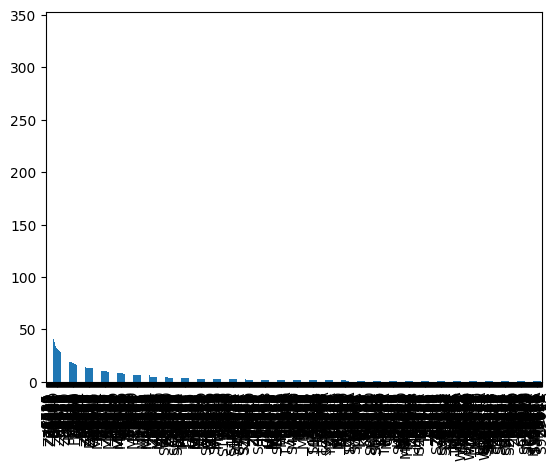

In [61]:
merged_no_dup['CODE'].value_counts().sort_values(ascending=False).plot(kind='bar')

In [62]:
merged_no_dup['CODE'].value_counts().sort_values(ascending=False)[:20]

I10       336
E785      185
I2510     157
E039       86
R079       84
K219       80
Z79899     70
E119       68
Z1231      60
Z7982      60
Z87891     56
R0602      56
I4891      52
N390       48
E7800      46
N179       41
R0789      38
I480       38
R109       37
J449       34
Name: CODE, dtype: int64

In [63]:
def fix_cardinality(merged_no_dup, column, new_value ,in_freq = 30, ):
    # count frequencies of each value in the column
    value_counts = merged_no_dup[column].value_counts()

    # create dictionary mapping values to their frequencies
    freq_dict = dict(value_counts)

    # assign a unique value to all values with frequency less than 30
    for value, freq in freq_dict.items():
        if freq < in_freq:
            merged_no_dup.loc[merged_no_dup[column] == value, column] = new_value 
    return merged_no_dup

In [64]:
merged_no_dup = fix_cardinality(merged_no_dup,column='HCPCS_CODE', in_freq=50, new_value='G8979')
merged_no_dup.shape


(5571, 27)

In [65]:
merged_no_dup = fix_cardinality(merged_no_dup,column='COUNTY', in_freq=50, new_value='COUNTY_X')
merged_no_dup.shape

(5571, 27)

In [66]:
merged_no_dup = fix_cardinality(merged_no_dup,column='CODE', in_freq=173, new_value="CODE_X")
merged_no_dup.shape

(5571, 27)

In [67]:
categorcal_cols_original = categorcal_cols

In [68]:
categorcal_cols = [col for col in categorcal_cols if col != 'REASON_CODE']
len(categorcal_cols)

22

In [69]:
dumy_encoded = pd.get_dummies(merged_no_dup,columns=categorcal_cols,drop_first=True)
dumy_encoded.shape

(5571, 572)

In [70]:
dumy_encoded.head()

APPROVED_CHARGE  REASON_CODE  Age  SERVICE_UNIT_QUANTITY  TOTAL_CHARGES  \
0            44.62         22.0   38                      1         225.62   
1          1457.06         27.0   84                     10        1638.06   
2           254.95         74.0   81                      1         326.95   
3             4.09         32.0   92                      1          76.09   
4            56.11          8.0   69                      1         173.11   

   BILL_TYPE_CODE_111  BILL_TYPE_CODE_112  BILL_TYPE_CODE_117  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

   BILL_TYPE_CODE_11I  BILL_TYPE_CODE_124  ...  MS_DRG_442  MS_DRG_470  \
0                   0                   0  ...           0           0   
1                   0                   0  ...           0           1   
2                   0                   0  ...           0           0   
3                   0                   0  ...           0           0   
4                   0                   0  ...           0           0   

   MS_DRG_481  MS_DRG_603  MS_DRG_641  MS_DRG_683  MS_DRG_690  MS_DRG_871  \
0           0           0           0           1           0           0   
1           0           0           0           0           0           0   
2           0           0           1           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   MS_DRG_872  MS_DRG_920  
0           0           0  
1           0           0  
2           0           0  
3           0           0  
4           0           0  

[5 rows x 572 columns]

In [71]:
dumy_encoded.describe()

APPROVED_CHARGE  REASON_CODE          Age  SERVICE_UNIT_QUANTITY  \
count      5571.000000  5571.000000  5571.000000            5571.000000   
mean       1736.904872    20.439957    76.418955               4.842757   
std        3128.347528    36.800624    12.533418              20.989115   
min         -82.700000     1.000000    19.000000               0.000000   
25%          53.170000     1.000000    71.000000               1.000000   
50%         252.460000     1.000000    76.000000               1.000000   
75%        1764.945000    22.000000    84.000000               1.000000   
max       28868.840000   118.000000   104.000000             510.000000   

       TOTAL_CHARGES  BILL_TYPE_CODE_111  BILL_TYPE_CODE_112  \
count    5571.000000         5571.000000         5571.000000   
mean     1783.341418            0.131933            0.000180   
std      3116.149816            0.338449            0.013398   
min       -36.430000            0.000000            0.000000   
25%       108.620000            0.000000            0.000000   
50%       343.330000            0.000000            0.000000   
75%      1786.520000            0.000000            0.000000   
max     28868.840000            1.000000            1.000000   

       BILL_TYPE_CODE_117  BILL_TYPE_CODE_11I  BILL_TYPE_CODE_124  ...  \
count         5571.000000         5571.000000         5571.000000  ...   
mean             0.008078            0.006103            0.000180  ...   
std              0.089519            0.077890            0.013398  ...   
min              0.000000            0.000000            0.000000  ...   
25%              0.000000            0.000000            0.000000  ...   
50%              0.000000            0.000000            0.000000  ...   
75%              0.000000            0.000000            0.000000  ...   
max              1.000000            1.000000            1.000000  ...   

        MS_DRG_442   MS_DRG_470   MS_DRG_481   MS_DRG_603   MS_DRG_641  \
count  5571.000000  5571.000000  5571.000000  5571.000000  5571.000000   
mean      0.067313     0.028182     0.020104     0.015258     0.024233   
std       0.250586     0.165506     0.140369     0.122587     0.153784   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

        MS_DRG_683   MS_DRG_690   MS_DRG_871   MS_DRG_872   MS_DRG_920  
count  5571.000000  5571.000000  5571.000000  5571.000000  5571.000000  
mean      0.036977     0.013104     0.028182     0.024771     0.026387  
std       0.188723     0.113729     0.165506     0.155441     0.160297  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000     0.000000     0.000000  
max       1.000000     1.000000     1.000000     1.000000     1.000000  

[8 rows x 572 columns]

### Features to be Normalized/Standardized

In [72]:
norm_features = []
desc = dumy_encoded.describe()
for col in desc.columns:
    if desc.loc[:,col]['std'] > 1:
        norm_features.append(col)
        #print(col)

norm_features.remove('REASON_CODE')
print(f' Features to be Normalized are : {norm_features}')

 Features to be Normalized are : ['APPROVED_CHARGE', 'Age', 'SERVICE_UNIT_QUANTITY', 'TOTAL_CHARGES']


In [73]:
dumy_encoded[norm_features].describe()

APPROVED_CHARGE          Age  SERVICE_UNIT_QUANTITY  TOTAL_CHARGES
count      5571.000000  5571.000000            5571.000000    5571.000000
mean       1736.904872    76.418955               4.842757    1783.341418
std        3128.347528    12.533418              20.989115    3116.149816
min         -82.700000    19.000000               0.000000     -36.430000
25%          53.170000    71.000000               1.000000     108.620000
50%         252.460000    76.000000               1.000000     343.330000
75%        1764.945000    84.000000               1.000000    1786.520000
max       28868.840000   104.000000             510.000000   28868.840000

Create X, y 

In [74]:
X = dumy_encoded.drop(columns='REASON_CODE')
y = dumy_encoded['REASON_CODE']
print(f'X:{X.shape} \n y:{y.shape}')

X:(5571, 571) 
 y:(5571,)


In [75]:
""" X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y)
print(f'X_train : {X_train.shape}\n X_test:{X_test.shape}\n y_train:{y_train.shape}\n y_test:{y_test.shape}') """

" X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y)\nprint(f'X_train : {X_train.shape}\n X_test:{X_test.shape}\n y_train:{y_train.shape}\n y_test:{y_test.shape}') "

#### Oversampling

##### SMOTE-NC

In [76]:
categorcal_cols_indices = list(range(4,570))
smnc = SMOTENC(
    sampling_strategy='auto', # samples only the minority class
    random_state=0,  # for reproducibility
    k_neighbors=5,
    n_jobs=4,
    categorical_features= categorcal_cols_indices# indeces of the columns of categorical variables
)

X_res, y_res = smnc.fit_resample(X, y)

/home/abhijitbarman/abhijit/WS/envs/claims_env/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:572: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/home/abhijitbarman/abhijit/WS/envs/claims_env/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [77]:
y_res.value_counts()

22.0     3682
27.0     3682
13.0     3682
115.0    3682
29.0     3682
118.0    3682
4.0      3682
6.0      3682
24.0     3682
31.0     3682
114.0    3682
7.0      3682
76.0     3682
5.0      3682
26.0     3682
117.0    3682
21.0     3682
9.0      3682
10.0     3682
90.0     3682
116.0    3682
74.0     3682
32.0     3682
8.0      3682
14.0     3682
18.0     3682
111.0    3682
16.0     3682
19.0     3682
11.0     3682
23.0     3682
112.0    3682
20.0     3682
33.0     3682
12.0     3682
1.0      3682
Name: REASON_CODE, dtype: int64

### Splitting of dataset into train and test

In [78]:

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=42,stratify=y_res)

In [79]:
print(f'X_train : {X_train.shape}\n X_test:{X_test.shape}\n y_train:{y_train.shape}\n y_test:{y_test.shape}')

X_train : (99414, 571)
 X_test:(33138, 571)
 y_train:(99414,)
 y_test:(33138,)


In [80]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(le_name_mapping)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

{1.0: 0, 4.0: 1, 5.0: 2, 6.0: 3, 7.0: 4, 8.0: 5, 9.0: 6, 10.0: 7, 11.0: 8, 12.0: 9, 13.0: 10, 14.0: 11, 16.0: 12, 18.0: 13, 19.0: 14, 20.0: 15, 21.0: 16, 22.0: 17, 23.0: 18, 24.0: 19, 26.0: 20, 27.0: 21, 29.0: 22, 31.0: 23, 32.0: 24, 33.0: 25, 74.0: 26, 76.0: 27, 90.0: 28, 111.0: 29, 112.0: 30, 114.0: 31, 115.0: 32, 116.0: 33, 117.0: 34, 118.0: 35}


### Feature Normalization

In [81]:
scaler = MinMaxScaler()
scaler.fit(X_train[norm_features])

MinMaxScaler()

In [82]:
norm_features

['APPROVED_CHARGE', 'Age', 'SERVICE_UNIT_QUANTITY', 'TOTAL_CHARGES']

In [83]:
scaled = scaler.transform(X_train[norm_features])
# ['SERVICE_UNIT_QUANTITY', 'APPROVED_CHARGE', 'Age', 'TOTAL_CHARGES']
X_train['SERVICE_UNIT_QUANTITY'] =  scaled[:,0]
X_train['APPROVED_CHARGE'] =  scaled[:,1]
X_train['Age'] = scaled[:,2]
X_train['TOTAL_CHARGES'] = scaled[:,3]
X_train.shape

(99414, 571)

In [84]:
X_train[norm_features]

APPROVED_CHARGE       Age  SERVICE_UNIT_QUANTITY  TOTAL_CHARGES
55320          0.647059  0.001961               0.005176       0.007505
66586          0.705882  0.001961               0.004379       0.006314
117549         0.788235  0.001961               0.006895       0.014061
52293          0.847059  0.001961               0.003123       0.009519
57755          0.764706  0.001961               0.015710       0.019356
...                 ...       ...                    ...            ...
75068          0.505882  0.001961               0.005626       0.007540
114428         0.682353  0.001961               0.020950       0.023396
110636         0.929412  0.021569               0.011413       0.011942
117869         0.729412  0.001961               0.006812       0.014995
10060          0.505882  0.001961               0.006181       0.008410

[99414 rows x 4 columns]

### ML Algorithms

#### Logistic Regression

In [85]:

lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', multi_class='multinomial')
lr_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial')

In [86]:
scaled = scaler.transform(X_test[norm_features])

X_test['SERVICE_UNIT_QUANTITY'] =  scaled[:,0]
X_test['APPROVED_CHARGE'] =  scaled[:,1]
X_test['Age'] = scaled[:,2]
X_test['TOTAL_CHARGES'] = scaled[:,3]

X_test.shape

(33138, 571)

In [87]:
preds = lr_model.predict(X_test)
train_preds = lr_model.predict(X_train)

In [88]:
print(f'LogisticRegression Test Accuracy: {accuracy_score(y_test, preds) * 100:.2f}')
print(f'LogisticRegression Train Accuracy: {accuracy_score(y_train, train_preds) * 100:.2f}')

LogisticRegression Test Accuracy: 100.00
LogisticRegression Train Accuracy: 100.00


In [89]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       920
           1       1.00      1.00      1.00       921
           2       1.00      1.00      1.00       921
           3       1.00      1.00      1.00       921
           4       1.00      1.00      1.00       920
           5       1.00      1.00      1.00       920
           6       1.00      1.00      1.00       921
           7       1.00      1.00      1.00       921
           8       1.00      1.00      1.00       920
           9       1.00      1.00      1.00       920
          10       1.00      1.00      1.00       921
          11       1.00      1.00      1.00       921
          12       1.00      1.00      1.00       920
          13       1.00      1.00      1.00       920
          14       1.00      1.00      1.00       921
          15       1.00      1.00      1.00       920
          16       1.00      1.00      1.00       920
          17       1.00    

##### ROC Curve

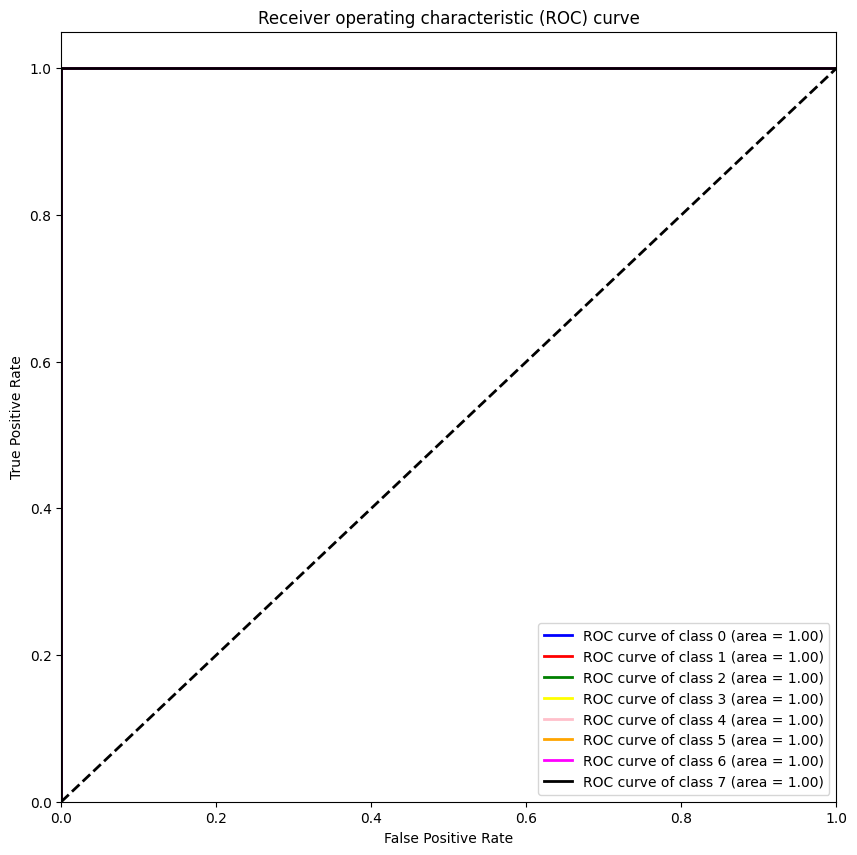

In [90]:

# Predict the probabilities for the test data
y_score = lr_model.predict_proba(X_test)

# Binarize the labels (convert to one-hot encoding)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2,3,4,5,6,7])
n_classes = y_test_bin.shape[1]

# Calculate the ROC curve and AUC score for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure(figsize=(10,10))
colors = cycle(['blue','red','green','yellow','pink','orange','magenta','black'])

for i, color in zip(range(n_classes), colors): 
  plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'
  ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

##### Confusion Matrix

In [91]:
disP_labels  = [str(int(i)) for i in y.unique().tolist()]
len(disP_labels)

36

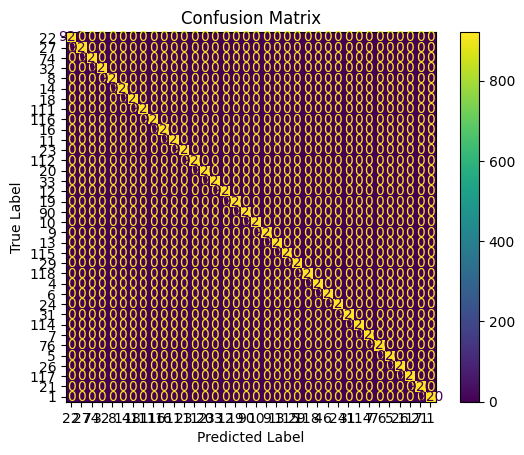

In [92]:

# Compute confusion matrix
cm = confusion_matrix(y_test,preds)

# Display confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=disP_labels)
disp.plot()

# Set plot properties
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


### Decision Tree

In [93]:
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [94]:
pred_test= dt_model.predict(X_test)
pred_train= dt_model.predict(X_train)

In [95]:
print(f'DecisionTreeClassifier Test Accuracy: {accuracy_score(y_test, pred_test) * 100:.2f}')
print(f'DecisionTreeClassifier Train Accuracy: {accuracy_score(y_train, pred_train) * 100:.2f}')

DecisionTreeClassifier Test Accuracy: 100.00
DecisionTreeClassifier Train Accuracy: 100.00


In [96]:
print(classification_report(y_test,pred_test))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       920
           1       1.00      1.00      1.00       921
           2       1.00      1.00      1.00       921
           3       1.00      1.00      1.00       921
           4       1.00      1.00      1.00       920
           5       1.00      1.00      1.00       920
           6       1.00      1.00      1.00       921
           7       1.00      1.00      1.00       921
           8       1.00      1.00      1.00       920
           9       1.00      1.00      1.00       920
          10       1.00      1.00      1.00       921
          11       1.00      1.00      1.00       921
          12       1.00      1.00      1.00       920
          13       1.00      1.00      1.00       920
          14       1.00      1.00      1.00       921
          15       1.00      1.00      1.00       920
          16       1.00      1.00      1.00       920
          17       1.00    

##### ROC Curve

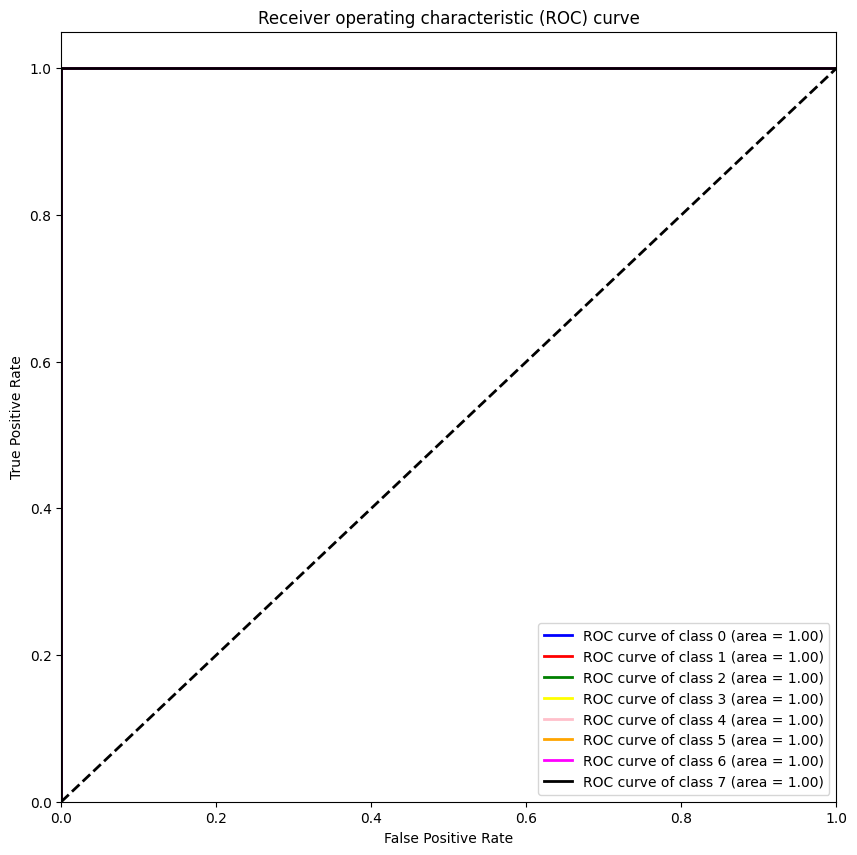

In [97]:

# Predict the probabilities for the test data
y_score = dt_model.predict_proba(X_test)

# Binarize the labels (convert to one-hot encoding)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2,3,4,5,6,7])
n_classes = y_test_bin.shape[1]

# Calculate the ROC curve and AUC score for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure(figsize=(10,10))
colors = cycle(['blue','red','green','yellow','pink','orange','magenta','black'])

for i, color in zip(range(n_classes), colors): 
  plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'
  ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

##### Confusion Matrix

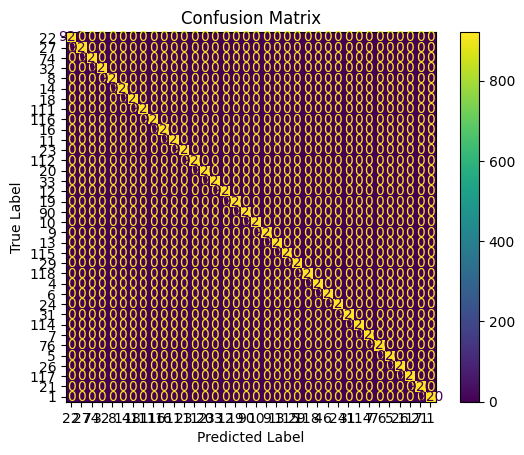

In [98]:

# Compute confusion matrix
cm = confusion_matrix(y_test,pred_test)

# Display confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=disP_labels)
disp.plot()

# Set plot properties
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


### Random forest Classifier

In [99]:

rf_model = RandomForestClassifier(random_state = 24, n_jobs = -1, class_weight='balanced')
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=24)

In [100]:
pred_train = rf_model.predict(X_train)
pred_test = rf_model.predict(X_test)

In [101]:
print(f'RandomForestClassifier Test Accuracy: {accuracy_score(y_test, pred_test) * 100:.2f}')
print(f'RandomForestClassifier Train Accuracy: {accuracy_score(y_train, pred_train) * 100:.2f}')

RandomForestClassifier Test Accuracy: 100.00
RandomForestClassifier Train Accuracy: 100.00


In [102]:
print(classification_report(y_test,pred_test))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       920
           1       1.00      1.00      1.00       921
           2       1.00      1.00      1.00       921
           3       1.00      1.00      1.00       921
           4       1.00      1.00      1.00       920
           5       1.00      1.00      1.00       920
           6       1.00      1.00      1.00       921
           7       1.00      1.00      1.00       921
           8       1.00      1.00      1.00       920
           9       1.00      1.00      1.00       920
          10       1.00      1.00      1.00       921
          11       1.00      1.00      1.00       921
          12       1.00      1.00      1.00       920
          13       1.00      1.00      1.00       920
          14       1.00      1.00      1.00       921
          15       1.00      1.00      1.00       920
          16       1.00      1.00      1.00       920
          17       1.00    

##### ROC Curve

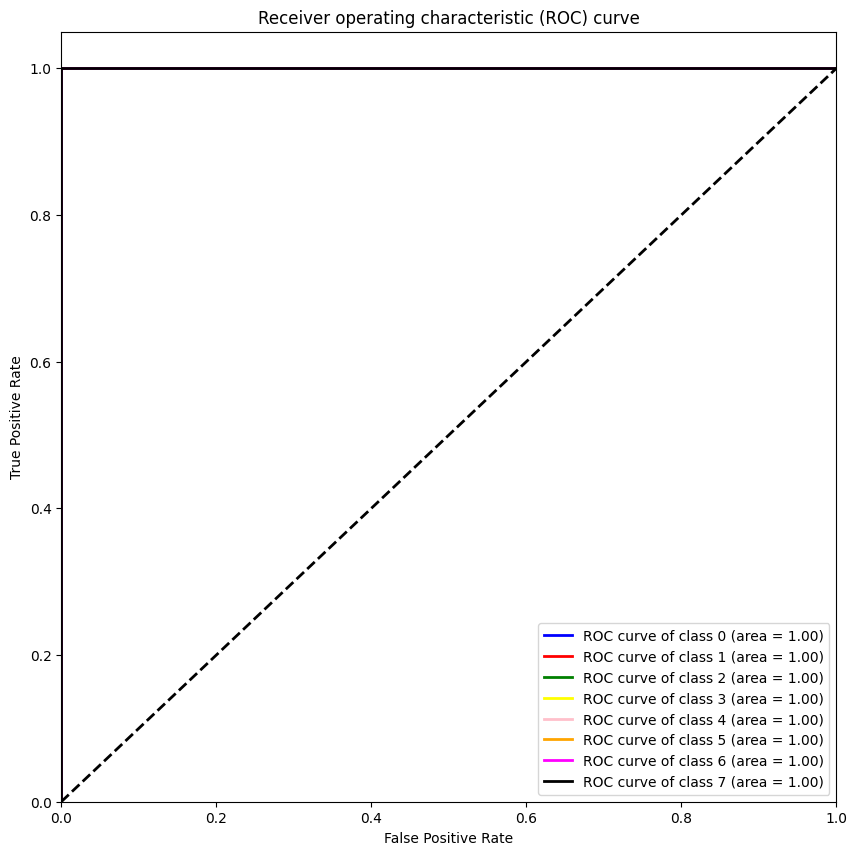

In [103]:

# Predict the probabilities for the test data
y_score = rf_model.predict_proba(X_test)

# Binarize the labels (convert to one-hot encoding)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2,3,4,5,6,7])
n_classes = y_test_bin.shape[1]

# Calculate the ROC curve and AUC score for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure(figsize=(10,10))
colors = cycle(['blue','red','green','yellow','pink','orange','magenta','black'])

for i, color in zip(range(n_classes), colors): 
  plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'
  ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

##### Confusion Matrix

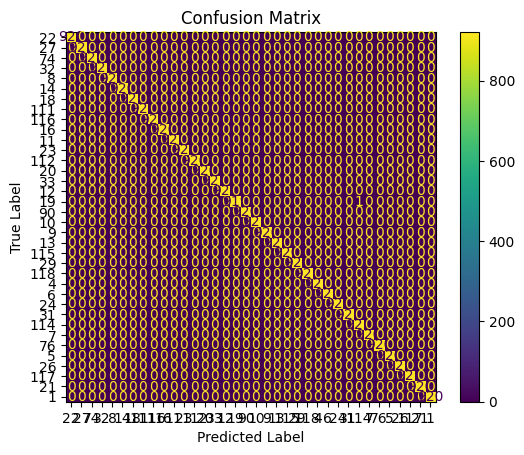

In [104]:

# Compute confusion matrix
cm = confusion_matrix(y_test,pred_test)

# Display confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=disP_labels)
disp.plot()

# Set plot properties
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

